In [1]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [26]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [27]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *

from infrarisk.src.physical.interdependencies import *

from infrarisk.src.optimizer import *
import infrarisk.src.plots as model_plots

## Create an IntegratedNetwork object

In [28]:
simple_network = IntegratedNetwork(name = "Simple")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [29]:
MAIN_DIR = Path('..')

network_dir= 'infrarisk/data/networks/in2'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_folder, 
                             power_folder, 
                             transp_folder, '1ph',
                             water_sim_type = "PDA")

Water network successfully loaded from ..\infrarisk\data\networks\in2\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\infrarisk\data\networks\in2\power\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\infrarisk\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [30]:
simple_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [31]:
dependency_file = MAIN_DIR/f"{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [32]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B1,T_J2,power,Bus,180.28
1,P_B2,T_J5,power,Bus,111.80
2,P_B3,T_J5,power,Bus,141.42
3,P_B4,T_J8,power,Bus,100.00
4,P_B5,T_J7,power,Bus,100.00


### Set failed components

In [33]:
scenario_folder = "scenarios/test1"
scenario_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.csv"

simple_network.set_disrupted_components(scenario_file=scenario_file)
simple_network.get_disrupted_components()

['W_P21', 'W_WP9', 'T_L2', 'P_L5']

### Set initial crew locations

In [34]:
simple_network.deploy_crews(
    init_power_crew_locs=['T_J8'], 
    init_water_crew_locs=['T_J8'],
    init_transpo_crew_locs= ['T_J8']
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery and Optimizer objects

In [35]:
network_recovery = NetworkRecovery(simple_network, 
                                   sim_step=60, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 10, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 10)
bf_optimizer = BruteForceOptimizer(prediction_horizon = 2)

### (b) Create a simulation object

In [36]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Optimization of repair strategy

In [37]:
bf_optimizer.find_optimal_recovery(bf_simulation)

PREDICTION HORIZON 1
**************************************************
Components to repair:  ['W_P21', 'W_WP9', 'T_L2', 'P_L5'] Components repaired:  []
Repair orders under consideration in the current prediction horizon:  [['W_P21', 'W_WP9'], ['W_P21', 'T_L2'], ['W_P21', 'P_L5'], ['W_WP9', 'W_P21'], ['W_WP9', 'T_L2'], ['W_WP9', 'P_L5'], ['T_L2', 'W_P21'], ['T_L2', 'W_WP9'], ['T_L2', 'P_L5'], ['P_L5', 'W_P21'], ['P_L5', 'W_WP9'], ['P_L5', 'T_L2']]
--------------------------------------------------
Simulating the current cumulative repair order ['W_P21', 'W_WP9'] ...
['T_L19'] 4.0
Repair W_P21: The water crew 1 is at T_J8 at t = 100.0  minutes. It takes 14 minutes to reach nearest node T_J5, the nearest transportation  node from W_P21.
['T_L13', 'T_L15'] 9.0
Repair W_WP9: The water crew 1 is at T_J5 at t = 474.0  minutes. It takes 19 minutes to reach nearest node T_J2, the nearest transportation  node from W_WP9.
All restoration actions are successfully scheduled.
[60, 6060, 6900, 283

### Plot the direct and interdependent effects

In [38]:
bf_optimizer.get_optimization_log()

,repair_order,water_auc,power_auc,auc
0,"[W_P21, W_WP9]",11.893,0.630,6.262
1,"[W_P21, T_L2]",11.893,0.630,6.262
2,"[W_P21, P_L5]",8.393,0.131,4.262
3,"[W_WP9, W_P21]",10.472,0.459,5.466
4,"[W_WP9, T_L2]",10.472,0.459,5.466
5,"[W_WP9, P_L5]",3.917,0.131,2.024
6,"[T_L2, W_P21]",11.893,0.630,6.262
7,"[T_L2, W_WP9]",10.472,0.459,5.466
8,"[T_L2, P_L5]",11.605,0.131,5.868
9,"[P_L5, W_P21]",8.393,0.131,4.262


In [39]:
bf_optimizer.best_repair_strategy

['T_L2', 'W_WP9', 'P_L5', 'W_P21']

In [47]:
bf_optimizer.resilience_metrics.calculate_power_resmetric(network_recovery)

The power Resilience Metric value based on ECS is 0.888 equivalent outage hours (EOH)
The power Resilience Metric value based on PCS is 0.131 equivalent outage hours (EOH)


In [48]:
bf_optimizer.resilience_metrics.calculate_water_resmetrics(network_recovery)

The water Resilience Metric value based on ECS is 2.655 equivalent outage hours (EOH)
The water Resilience Metric value based on PCS is 2.616 equivalent outage hours (EOH)


In [49]:
bf_optimizer.resilience_metrics.set_weighted_auc_metrics()

The weighted AUC value based on ECS is 1.7714999999999999
The weighted AUC value based on PCS is 1.3735


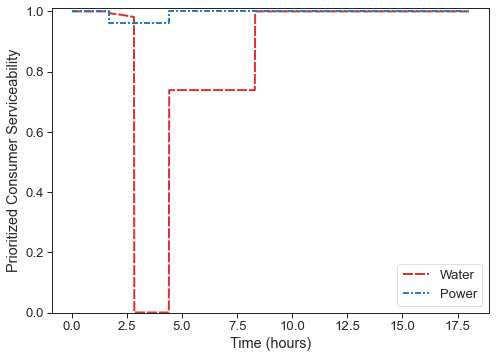

In [46]:
model_plots.plot_interdependent_effects(bf_optimizer.resilience_metrics, metric = 'pcs', title = False)